# Introduction to LangGraph

LangGraph is a framework for creating applications using graph-based workflows. Each node represents a function or computational step, and edges define the flow between these nodes based on certain conditions.

## Key Features:
- State Management
- Flexible Routing
- Persistence
- Visualization

## Tutorial Overview: Text Analysis Pipeline

In this tutorial, we'll demonstrate the power of LangGraph by building a multi-step text analysis pipeline. Our use case will focus on processing a given text through three key stages:

1. **Text Classification**: We'll categorize the input text into predefined categories (e.g., News, Blog, Research, or Other).
2. **Entity Extraction**: We'll identify and extract key entities such as persons, organizations, and locations from the text.
3. **Text Summarization**: Finally, we'll generate a concise summary of the input text.

This pipeline showcases how LangGraph can be used to create a modular, extensible workflow for natural language processing tasks. By the end of this tutorial, you'll understand how to construct a graph-based application that can be easily modified or expanded for various text analysis needs.

### Import Required Libraries
This cell imports all the necessary modules and classes for our LangGraph tutorial.

In [28]:
import os
from typing import TypedDict, List
from langgraph.graph import StateGraph, END
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

from dotenv import load_dotenv

### Set Up API Key
This cell loads environment variables and sets up the OpenAI API key. Make sure you have a `.env` file with your `OPENAI_API_KEY`.

In [7]:
# Load environment variables
load_dotenv()

# Set OpenAI API key
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

## Building the Text Processing Pipeline

### Define State and Initialize LLM
Here we define the State class to hold our workflow data and initialize the ChatOpenAI model.

In [9]:
class State(TypedDict):
    text: str
    classification: str
    entities: List[str]
    summary: str

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

### Define Node Functions
These functions define the operations performed at each node of our graph: classification, entity extraction, and summarization.

In [20]:
def classification_node(state: State):
    ''' Classify the text into one of the categories: News, Blog, Research, or Other '''
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Classify the following text into one of the categories: News, Blog, Research, or Other.\n\nText:{text}\n\nCategory:"
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    classification = llm.invoke([message]).content.strip()
    return {"classification": classification}


def entity_extraction_node(state: State):
    ''' Extract all the entities (Person, Organization, Location) from the text '''
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Extract all the entities (Person, Organization, Location) from the following text. Provide the result as a comma-separated list.\n\nText:{text}\n\nEntities:"
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    entities = llm.invoke([message]).content.strip().split(", ")
    return {"entities": entities}


def summarization_node(state: State):
    ''' Summarize the text in one short sentence '''
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Summarize the following text in one short sentence.\n\nText:{text}\n\nSummary:"
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    summary = llm.invoke([message]).content.strip()
    return {"summary": summary}

### Create Tools and Build Workflow
This cell builds the StateGraph workflow.

In [21]:
workflow = StateGraph(State)

# Add nodes to the graph
workflow.add_node("classification_node", classification_node)
workflow.add_node("entity_extraction", entity_extraction_node)
workflow.add_node("summarization", summarization_node)

# Add edges to the graph
workflow.set_entry_point("classification_node") # Set the entry point of the graph
workflow.add_edge("classification_node", "entity_extraction")
workflow.add_edge("entity_extraction", "summarization")
workflow.add_edge("summarization", END)

# Compile the graph
app = workflow.compile()

## Visualizing the Workflow
This cell creates a visual representation of our workflow using Mermaid

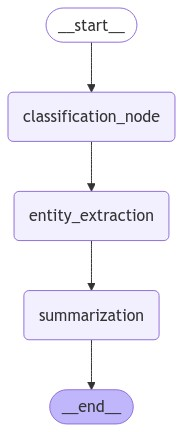

In [29]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Testing the Pipeline
This cell runs a sample text through our pipeline and displays the results.

In [22]:
sample_text = """
OpenAI has announced the GPT-4 model, which is a large multimodal model that exhibits human-level performance on various professional benchmarks. It is developed to improve the alignment and safety of AI systems.
additionally, the model is designed to be more efficient and scalable than its predecessor, GPT-3. The GPT-4 model is expected to be released in the coming months and will be available to the public for research and development purposes.
"""

state_input = {"text": sample_text}
result = app.invoke(state_input)

print("Classification:", result["classification"])
print("\nEntities:", result["entities"])
print("\nSummary:", result["summary"])

Classification: News

Entities: ['OpenAI', 'GPT-4', 'GPT-3']

Summary: OpenAI's upcoming GPT-4 model is a multimodal AI that aims for human-level performance, improved safety, and greater efficiency compared to GPT-3.


## Conclusion

In this tutorial, we've:
- Explored LangGraph concepts
- Built a text processing pipeline
- Demonstrated LangGraph's use in data processing workflows
- Visualized the workflow using Mermaid

This example showcases how LangGraph can be used for tasks beyond conversational agents, providing a flexible framework for creating complex, graph-based workflows.